# Re-producing the Shift data
from the study "Flying in 2050"

## Hypothesis

In [1]:
import numpy as np
import configparser

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("./ipynb_inline.mplstyle")

from aviation import traj_objective, traj_ref, optimisation_traj

In [2]:

config = configparser.ConfigParser()
configfilename = "./aviation_parameters.ini"
config.read(configfilename)
config.sections()

['InitialState', 'ImpactCovid', 'referenceWord', 'ObjectifWord', 'simpleModel']

In [3]:
begin_year = float(config["InitialState"]["begin_year"])
emission_2018_fr = float(config["InitialState"]["emission_2018_fr"])
emission_2018_wd = float(config["InitialState"]["emission_2018_wd"])
budget_carbone_2018_50_fr = float(config["InitialState"]["budget_carbone_2018_50_fr"])
budget_carbone_2018_50_wd = float(config["InitialState"]["budget_carbone_2018_50_wd"])
years = np.arange(begin_year, 2051, 1. )

In [4]:

trajectory_ref_word = traj_ref(config, years)
        
trajectory_obj_word = traj_objective(config, years)


In [5]:
from scipy.interpolate import make_interp_spline, BSpline

# 300 represents number of points to make between T.min and T.max
yearsnew = np.linspace(years.min(), years.max(), 300) 



In [6]:
def startFigure(years, trajectory_ref_word):
    fig, ax = plt.subplots(1,1)
    
    spl = make_interp_spline(years, trajectory_ref_word, k=3, bc_type=([(1, 0.0)], [(2, 0.0)]))  # type: BSpline

    ax.plot(yearsnew, spl(yearsnew), label="reference trajectory, +4%/yr from 2024")
    ax.scatter(years, trajectory_ref_word, marker=".")
    ax.plot(years, trajectory_obj_word, label="objectif trajectory, -3.39%/yr")

    ax.set_title("Word trajectories from 2018")
    ax.set_xlabel("Year")
    ax.set_ylabel("Word emission [MtCO2]")
    
    return fig, ax



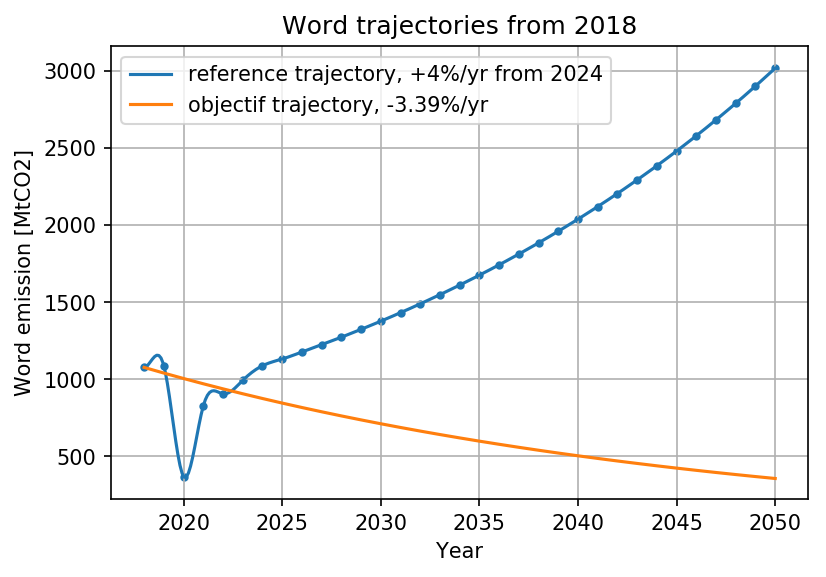

In [7]:
fig, ax = startFigure(years, trajectory_ref_word)

ax.legend()


In [8]:
optimisation_shortterm_operation = float(config["simpleModel"]["optimisation_shortterm_operation"])
optimisation_technologique = float(config["simpleModel"]["optimisation_technologique"])

In [9]:

traj_operation_wd = optimisation_traj(trajectory_ref_word, optimisation_shortterm_operation)
traj_techno_wd = optimisation_traj(traj_operation_wd, optimisation_technologique)


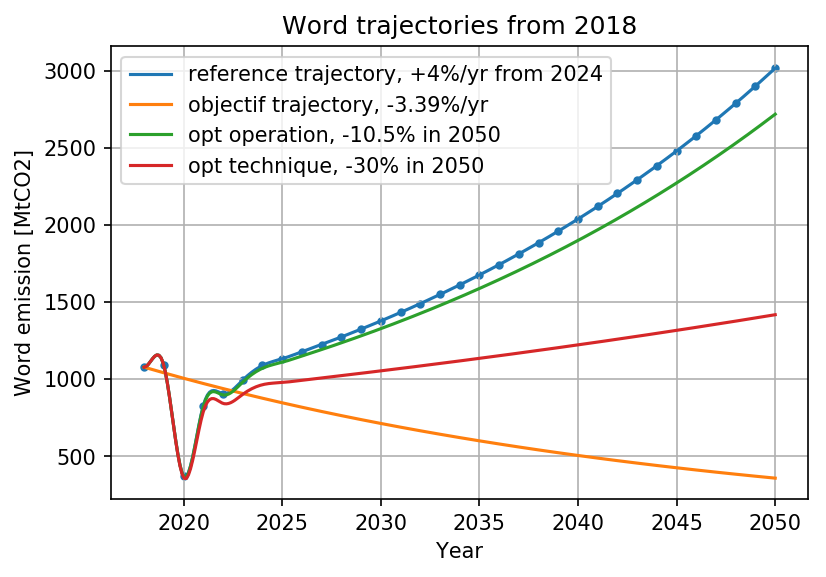

In [10]:

fig, ax = startFigure(years, trajectory_ref_word)
spl_op = make_interp_spline(years, traj_operation_wd, k=3, bc_type=([(1, 0.0)], [(2, 0.0)]))  # type: BSpline
spl_tech = make_interp_spline(years, traj_techno_wd, k=3, bc_type=([(1, 0.0)], [(2, 0.0)]))  # type: BSpline


ax.plot(yearsnew, spl_op(yearsnew), label="opt operation, -10.5% in 2050")
ax.plot(yearsnew, spl_tech(yearsnew), label="opt technique, -30% in 2050")

ax.legend()


# Evolution Secteur

Chapter 5.9, utilisant les objectifs du secteur

## Performance Techno

Estimation d'une amélioration de la performance de 2% par an

In [11]:
perf_techno_year = 0.02

In [12]:
traj_performances_wd = optimisation_traj(trajectory_ref_word, factor_yearly=perf_techno_year)
traj_altCarb_wd = optimisation_traj(traj_performances_wd, factor=0.5)


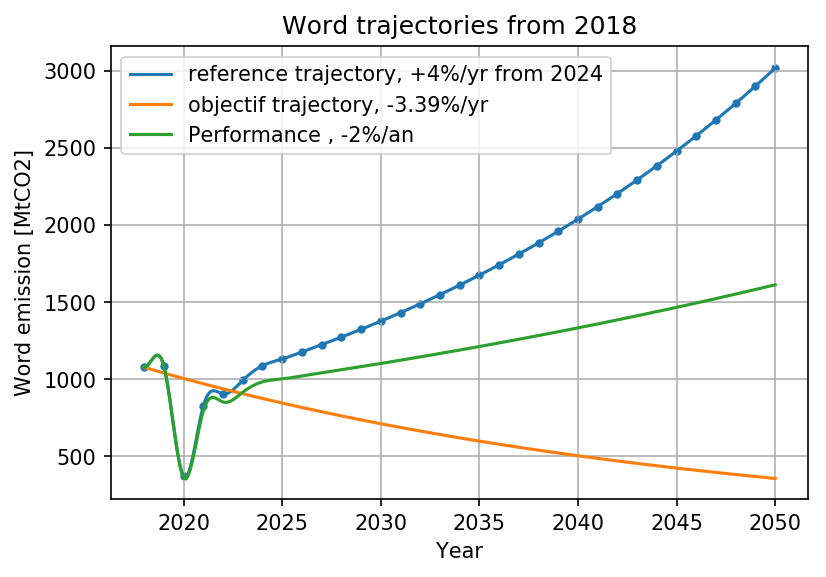

In [13]:

fig, ax = startFigure(years, trajectory_ref_word)
spl_perf = make_interp_spline(years, traj_performances_wd, k=3, bc_type=([(1, 0.0)], [(2, 0.0)]))  # type: BSpline

ax.plot(yearsnew, spl_perf(yearsnew), label="Performance , -2%/an")

ax.legend()


## Utilisation de Bio Carburant

- Flote actuelle ayant une capacité d'utilisation de 50 % de carburan alternatifs
- Flote future avec 100% d'utilisation à partir de 2035
- production de carburant alternatif, croissant géométriquement de 0% aujourd'hui à 100% en 2050

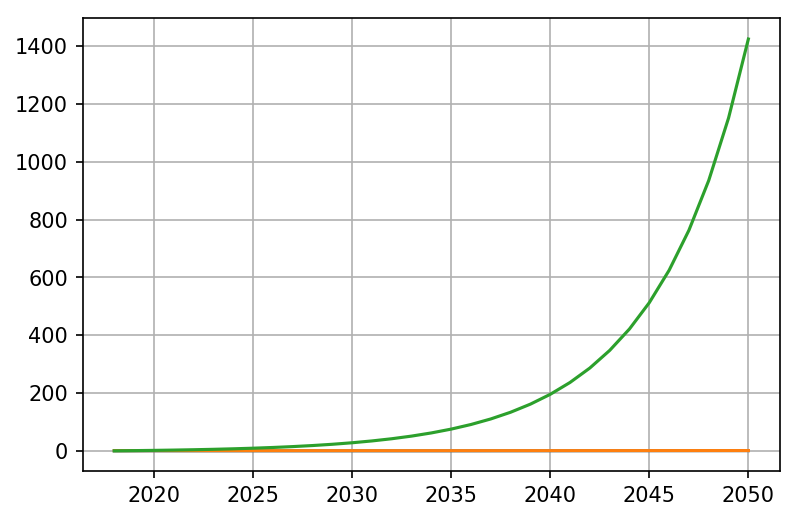

In [14]:
flot_altcarb_usability = np.ones_like(years)*0.5
flot_newmodels = np.zeros_like(years)
altCarb_disponibility = np.zeros_like(years)

index2035 = np.argwhere(years==2035)[0][0]
indexMan = len(years)

renewDuration = 20 # years
renewRate = 1/renewDuration

for i in range(index2035+1, indexMan):
    flot_newmodels[i] = flot_newmodels[i-1] + renewRate

flot_newmodels[flot_newmodels>1] = 1

for i in range(index2035, indexMan):
    flot_altcarb_usability[i] = flot_newmodels[i] * 1.0 + (1-flot_newmodels[i]) * 0.5

altCarb_disponibility[0] = 1.001

for i in range(1, indexMan):
    altCarb_disponibility[i] = altCarb_disponibility[i-1]**1.2

altCarb_disponibility -= altCarb_disponibility[0]
altCarb_disponibility /= altCarb_disponibility[-1]
altCarb_disponibility *= 500 * 2.85  # 500MT total capacuity of Fuil, Times 3 for the CO2 masse

plt.figure()
plt.plot(years, flot_newmodels)
plt.plot(years, flot_altcarb_usability)
plt.plot(years, altCarb_disponibility)

In [15]:
traj_altCarb_wd  = traj_performances_wd.copy()

for i in range(len(years)):
    traj_altCarb_wd[i] -=  altCarb_disponibility[i]
traj_altCarb_wd[-1]

187.51611522520352

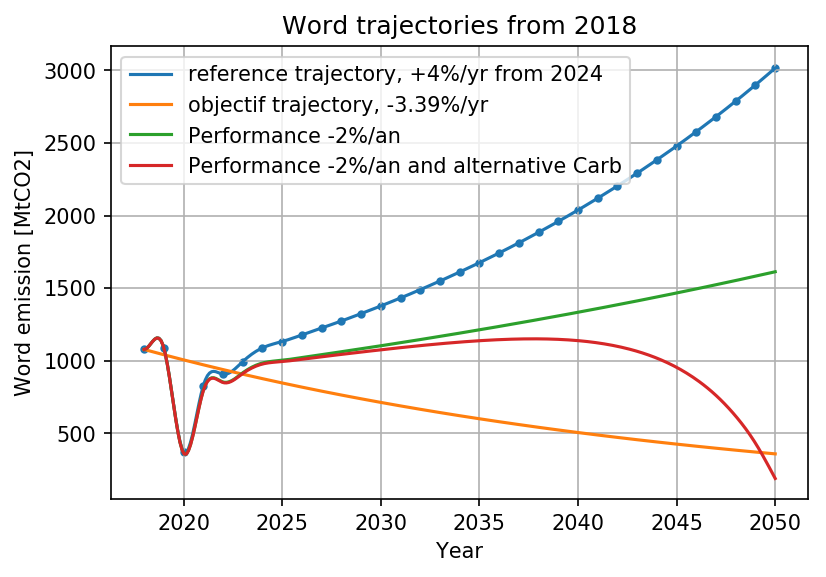

In [16]:

fig, ax = startFigure(years, trajectory_ref_word)
spl_perf = make_interp_spline(years, traj_performances_wd, k=3, bc_type=([(1, 0.0)], [(2, 0.0)]))  # type: BSpline
spl_altcarb = make_interp_spline(years, traj_altCarb_wd, k=3, bc_type=([(1, 0.0)], [(2, 0.0)]))  # type: BSpline

ax.plot(yearsnew, spl_perf(yearsnew), label="Performance -2%/an")
ax.plot(yearsnew, spl_altcarb(yearsnew), label="Performance -2%/an and alternative Carb")

ax.legend()


In [17]:
2.85*500

1425.0

## Comments
Ok, so I det the same figure than Figure 29 (page 51), but I don't understand why I don't get the same value.

Indeed, 500Mt of bio carburant and PTL leads to the reduction of 1425 to 1500 MtCo2. [[source]](https://www.engineeringtoolbox.com/co2-emission-fuels-d_1085.html)

This does not leads to a reduction from 1613 to 272 MtCO2, which correspond to a reduction of 1341MtCO2 (hence a specific CO2 emission of $2.262 $Kg$_{C02}/$Kg$_{fuel}$)


# Cumulé

(<Figure size 900x600 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc6119e5ac0>)

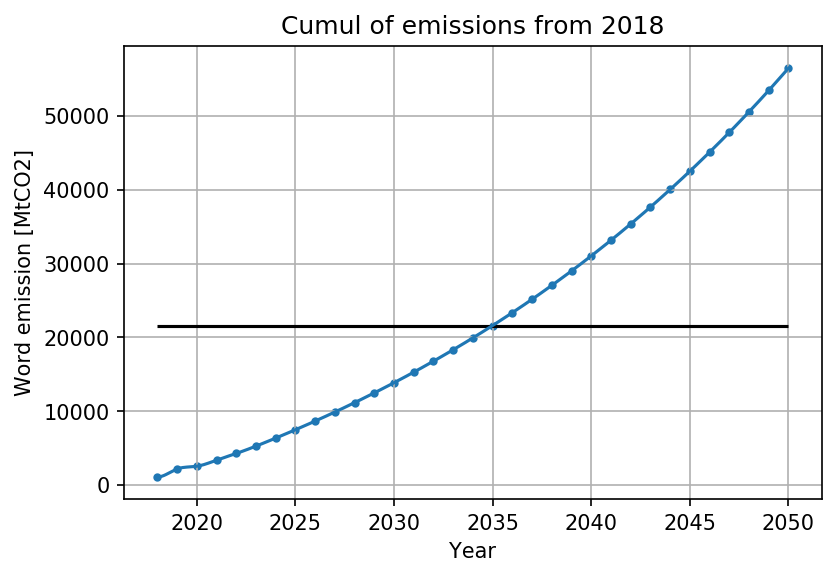

In [20]:
def startFigureCum(years, trajectory_ref_word):
    fig, ax = plt.subplots(1,1)
    
    trajectory_ref_wordCum = np.cumsum(trajectory_ref_word)
    
    spl = make_interp_spline(years, trajectory_ref_wordCum, k=3, bc_type=([(1, 0.0)], [(2, 0.0)]))  # type: BSpline

    ax.plot(yearsnew, spl(yearsnew), label="reference trajectory, +4%/yr from 2024")
    ax.scatter(years, trajectory_ref_wordCum, marker=".")
    
    ax.hlines(21596, 2018, 2050, label="objectif trajectory, -3.39%/yr")

    ax.set_title("Cumul of emissions from 2018")
    ax.set_xlabel("Year")
    ax.set_ylabel("Word emission [MtCO2]")
    
    return fig, ax



31679.835810543373

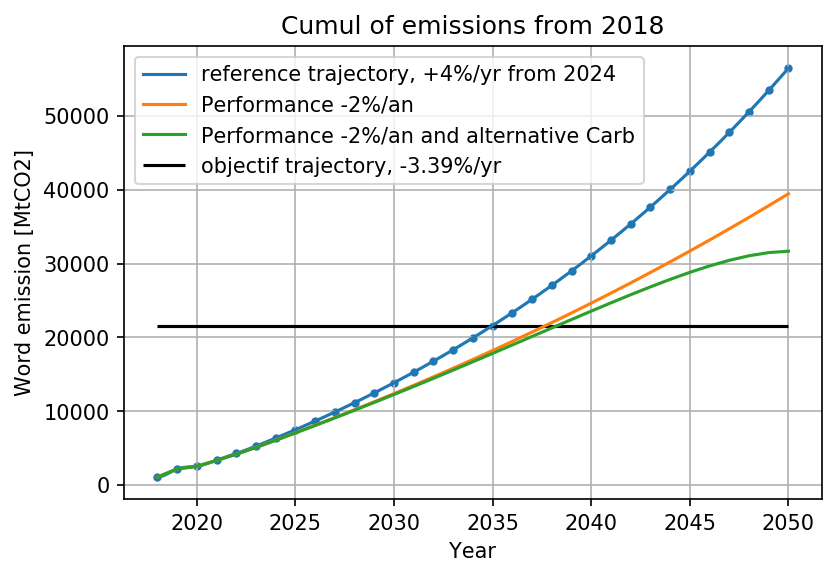

In [23]:
fig, ax = startFigureCum(years, trajectory_ref_word)

spl_altcarb = make_interp_spline(years, traj_altCarb_wd, k=3, bc_type=([(1, 0.0)], [(2, 0.0)]))  # type: BSpline

traj_altCarb_wdCum = np.cumsum(traj_altCarb_wd)
traj_performances_wdCum = np.cumsum(traj_performances_wd)

ax.plot(years, traj_performances_wdCum, label="Performance -2%/an")
ax.plot(years, traj_altCarb_wdCum, label="Performance -2%/an and alternative Carb")

ax.legend()

traj_altCarb_wdCum[-1]